<a href="https://colab.research.google.com/github/DJIbay/157-Guitar/blob/main/157_Ibay_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Imports ---
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from scipy.signal import savgol_filter
from IPython.display import Image as IPImage

In [ ]:
# --- Configurations ---
VIDEO_PATH = '/content/drive/MyDrive/157/guitar.mp4'
SAVE_DIR = '/content/drive/MyDrive/guitar_string_rotated_curves'
ROI = (180, 0, 230, 300)
FRET_ZONES = [85, 170, 255]
MAX_WINDOW = 101
POLY_ORDER = 2
GIF_PATH = os.path.join(SAVE_DIR, "vibrating_string.gif")

os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
# --- Helper Functions ---
def crop_to_roi(frame, roi):
    x1, y1, x2, y2 = roi
    return frame[y1:y2, x1:x2]

def preprocess(roi_frame):
    gray = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY) if roi_frame.ndim == 3 else roi_frame
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobel = cv2.convertScaleAbs(sobel_x)
    _, binary = cv2.threshold(abs_sobel, 50, 255, cv2.THRESH_BINARY)
    median = cv2.medianBlur(binary, 5)
    for center in FRET_ZONES:
        median[max(0, center - 5):center + 6, :] = 0
    return median

def morphological_clean(binary_frame):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 25))
    closed = cv2.morphologyEx(binary_frame, cv2.MORPH_CLOSE, kernel)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed)
    cleaned = np.zeros_like(binary_frame)
    best_score, best_label = 0, 0
    for i in range(1, num_labels):
        area, w, h = stats[i, cv2.CC_STAT_AREA], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
        if area > 50 and h > w * 2 and area > best_score:
            best_score = area
            best_label = i
    if best_label > 0:
        cleaned[labels == best_label] = 255
    return cleaned

def refine_curve(binary_frame):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    return cv2.erode(binary_frame, kernel, iterations=1)

def extract_curve(binary_frame):
    height = binary_frame.shape[0]
    return [
        int(np.median(x_vals)) if (x_vals := np.where(binary_frame[y, :] > 0)[0]).size else np.nan
        for y in range(height)
    ]

def interpolate_and_smooth(curve):
    curve_np = np.array(curve, dtype=np.float32)
    if np.all(np.isnan(curve_np)):
        return None
    if np.any(np.isnan(curve_np)):
        curve_np[np.isnan(curve_np)] = np.interp(
            np.flatnonzero(np.isnan(curve_np)),
            np.flatnonzero(~np.isnan(curve_np)),
            curve_np[~np.isnan(curve_np)]
        )
    win_len = MAX_WINDOW if len(curve_np) >= MAX_WINDOW else (len(curve_np) // 2) * 2 + 1
    return savgol_filter(curve_np, window_length=win_len, polyorder=POLY_ORDER, mode='interp')

In [ ]:
# --- Extract Curves and Save to CSV ---
cap = cv2.VideoCapture(VIDEO_PATH)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for frame_idx in range(frame_count):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    if not ret:
        print(f"Skipped frame {frame_idx}")
        continue

    binary = preprocess(crop_to_roi(frame, ROI))
    cleaned = morphological_clean(binary)
    refined = refine_curve(cleaned)
    curve_smooth = interpolate_and_smooth(extract_curve(refined))

    if curve_smooth is None:
        continue

    df = pd.DataFrame({
        'x_across_string': curve_smooth,
        'y_down_string': range(len(curve_smooth))
    })
    df.to_csv(os.path.join(SAVE_DIR, f'rotated_curve_frame_{frame_idx:04d}.csv'), index=False)
    print(f"Saved frame {frame_idx}")

cap.release()

Saved frame 0
Saved frame 1
Saved frame 2
Saved frame 3
Saved frame 4
Saved frame 5
Saved frame 6
Saved frame 7
Saved frame 8
Saved frame 9
Saved frame 10
Saved frame 11
Saved frame 12
Saved frame 13
Saved frame 14
Saved frame 15
Saved frame 16
Saved frame 17
Saved frame 18
Saved frame 19
Saved frame 20
Saved frame 21
Saved frame 22
Saved frame 23
Saved frame 24
Saved frame 25
Saved frame 26
Saved frame 27
Saved frame 28
Saved frame 29
Saved frame 30
Saved frame 31
Saved frame 32
Saved frame 33
Saved frame 34
Saved frame 35
Saved frame 36
Saved frame 37
Saved frame 38
Saved frame 39
Saved frame 40
Saved frame 41
Saved frame 42
Saved frame 43
Saved frame 44
Saved frame 45
Saved frame 46
Saved frame 47
Saved frame 48
Saved frame 49
Saved frame 50
Saved frame 51
Saved frame 52
Saved frame 53
Saved frame 54
Saved frame 55
Saved frame 56
Saved frame 57
Saved frame 58
Saved frame 59
Saved frame 60
Saved frame 61
Saved frame 62
Saved frame 63
Saved frame 64
Saved frame 65
Saved frame 66
Saved

In [ ]:
# --- Create GIF ---
csv_files = sorted([f for f in os.listdir(SAVE_DIR) if f.endswith(".csv")])
sample_df = pd.read_csv(os.path.join(SAVE_DIR, csv_files[0]))
new_width = sample_df['y_down_string'].max()
new_height = 50
aspect_ratio = new_height / new_width
fig_width = 8
fig_height = fig_width * aspect_ratio
frames = []

for csv_file in csv_files:
    df = pd.read_csv(os.path.join(SAVE_DIR, csv_file))
    x = df['y_down_string']
    y = np.clip(df['x_across_string'], 0, 50)
    if len(y) >= MAX_WINDOW:
        y = savgol_filter(y, window_length=MAX_WINDOW, polyorder=POLY_ORDER)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.plot(x, y, c='blue', linewidth=2)
    ax.set_xlim(0, new_width)
    ax.set_ylim(0, new_height)
    ax.set_title(f'Frame {csv_file[-8:-4]}')
    ax.set_xlabel("Y (down string)")
    ax.set_ylabel("X (across string)")
    ax.grid(True)
    temp_path = "/tmp/temp_frame.png"
    plt.savefig(temp_path, dpi=100, bbox_inches='tight')
    plt.close()
    frames.append(imageio.imread(temp_path))

imageio.mimsave(GIF_PATH, frames, duration=0.05)
print(f"Saved GIF to: {GIF_PATH}")

Saved GIF to: /content/drive/MyDrive/guitar_string_rotated_curves/vibrating_string.gif


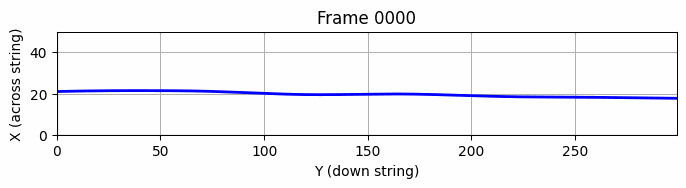

In [ ]:
# --- Display GIF in Colab ---
IPImage(filename=GIF_PATH)

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

OUTPUT_PATH = "/content/drive/MyDrive/guitar_superimposed_video.mp4"

In [ ]:
# Load video
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)

# Frame dimensions after rotation
width_roi = ROI[2] - ROI[0]
height_roi = ROI[3] - ROI[1]
rotated_size = (height_roi, width_roi)  # Because of 90° rotation

# Video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, rotated_size)

# CSVs
csv_files = sorted([f for f in os.listdir(SAVE_DIR) if f.endswith(".csv")])

for frame_idx, csv_file in enumerate(csv_files):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    if not ret:
        print(f"Skipping frame {frame_idx}")
        continue

    # Crop and rotate ROI (rotate clockwise to match curve orientation)
    roi_frame = frame[ROI[1]:ROI[3], ROI[0]:ROI[2]]
    roi_frame_rotated = cv2.rotate(roi_frame, cv2.ROTATE_90_CLOCKWISE)

    # Load curve
    df = pd.read_csv(os.path.join(SAVE_DIR, csv_file))
    x = df['y_down_string'].values
    y = np.clip(df['x_across_string'].values, 0, 50)
    if len(y) >= MAX_WINDOW:
        y = savgol_filter(y, MAX_WINDOW, POLY_ORDER)

    # Plot
    fig, ax = plt.subplots(figsize=(rotated_size[0] / 100, rotated_size[1] / 100), dpi=100)
    ax.imshow(cv2.cvtColor(roi_frame_rotated, cv2.COLOR_BGR2RGB))
    ax.plot(x, y, color='red', linewidth=2)
    ax.axis('off')
    fig.tight_layout(pad=0)

    # Render to image
    canvas = FigureCanvas(fig)
    canvas.draw()
    buf = np.asarray(canvas.buffer_rgba())
    img_bgr = cv2.cvtColor(buf, cv2.COLOR_RGBA2BGR)
    plt.close(fig)

    # Write frame
    out.write(img_bgr)
    print(f"Processed frame {frame_idx+1}/{len(csv_files)}")

cap.release()
out.release()
print(f"Overlay video saved to: {OUTPUT_PATH}")

Processed frame 1/662
Processed frame 2/662
Processed frame 3/662
Processed frame 4/662
Processed frame 5/662
Processed frame 6/662
Processed frame 7/662
Processed frame 8/662
Processed frame 9/662
Processed frame 10/662
Processed frame 11/662
Processed frame 12/662
Processed frame 13/662
Processed frame 14/662
Processed frame 15/662
Processed frame 16/662
Processed frame 17/662
Processed frame 18/662
Processed frame 19/662
Processed frame 20/662
Processed frame 21/662
Processed frame 22/662
Processed frame 23/662
Processed frame 24/662
Processed frame 25/662
Processed frame 26/662
Processed frame 27/662
Processed frame 28/662
Processed frame 29/662
Processed frame 30/662
Processed frame 31/662
Processed frame 32/662
Processed frame 33/662
Processed frame 34/662
Processed frame 35/662
Processed frame 36/662
Processed frame 37/662
Processed frame 38/662
Processed frame 39/662
Processed frame 40/662
Processed frame 41/662
Processed frame 42/662
Processed frame 43/662
Processed frame 44/6

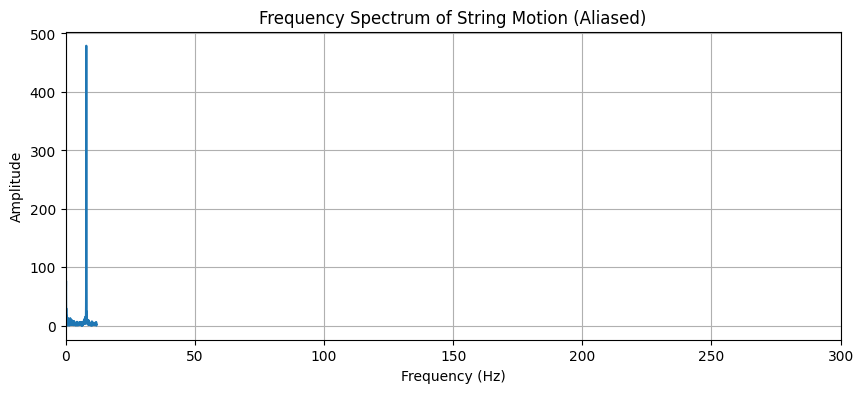

Observed alias frequency: 8.00 Hz
Best estimate: n = 3, f_true ≈ 80.00 Hz (expected ≈ 82.4 Hz)


In [ ]:
from scipy.signal import detrend, windows
from scipy.fft import rfft, rfftfreq

# --- Settings ---
start_frame = 64
end_frame = 661
probe_y = 180
curve_dir = "/content/drive/MyDrive/guitar_string_rotated_curves"
fps = 24  # Frame rate
expected_freq = 82.4  # Expected true frequency for low E string (E2)

# --- Load Displacement Signal ---
csv_files = sorted([f for f in os.listdir(SAVE_DIR) if f.endswith(".csv")])
selected_files = csv_files[start_frame:end_frame]
displacements = []

for file in selected_files:
    df = pd.read_csv(os.path.join(SAVE_DIR, file))
    x_val = np.interp(probe_y, df['y_down_string'], df['x_across_string'])
    displacements.append(x_val)

displacements = np.array(displacements)

# --- Preprocess Signal ---
signal = detrend(displacements)
window = windows.hamming(len(signal))
signal *= window

# --- FFT ---
N = len(signal)
yf = rfft(signal)
xf = rfftfreq(N, 1 / fps)

# --- Plot Frequency Spectrum ---
plt.figure(figsize=(10, 4))
plt.plot(xf, np.abs(yf))
plt.title("Frequency Spectrum of String Motion (Aliased)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 300)
plt.grid(True)
plt.show()

# --- Estimate Aliased and True Frequency ---

alias_freq = xf[np.argmax(np.abs(yf))]

def estimate_true_freq(alias_freq, sampling_rate, expected_freq, max_n=10):
    best_n = None
    best_freq = None
    min_error = float('inf')
    for n in range(1, max_n + 1):
        for f_true in [n * sampling_rate + alias_freq, abs(n * sampling_rate - alias_freq)]:
            error = abs(f_true - expected_freq)
            if error < min_error:
                min_error = error
                best_freq = f_true
                best_n = n
    return best_n, best_freq

n, true_freq = estimate_true_freq(alias_freq, fps, expected_freq)

# --- Report ---
print(f"Observed alias frequency: {alias_freq:.2f} Hz")
print(f"Best estimate: n = {n}, f_true ≈ {true_freq:.2f} Hz (expected ≈ {expected_freq} Hz)")